In [2]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import pathlib

import matplotlib as mpl
mpl.style.use('bmh')
import matplotlib.pyplot as plt
from matplotlib import colors

import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely import geometry
import rasterio
from rasterio.transform import (
    Affine,
    from_bounds,
)
from rasterio.crs import CRS
from rasterio.features import rasterize
from rasterio import plot as rplt

from diveg import grid
from diveg.statistics import iqr

from cwd import cwd

In [4]:
ifname = 'insar-test.gpkg'
assert pathlib.Path(ifname).is_file()
points = gpd.read_file(ifname, layer='2D')
norm = colors.TwoSlopeNorm(vmin=points.VEL_V.min(), vcenter=0, vmax=points.VEL_V.max())

/home/e088195/bin/miniconda3/envs/diveg/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [5]:
if True:
    points = points.to_crs('epsg:25832')
    POINT_DISTANCE_OBSERVED = 80.0  # [m]
else:
    POINT_DISTANCE_OBSERVED = 0.000720  # [deg]

In [6]:
# Load commune borders to see the land around the cells
ifname_adm = pathlib.Path.home() / 'data' / 'administrative' / 'KOMMUNE.shp'
adm = gpd.read_file(ifname_adm)
adm = adm.to_crs(points.crs)

In [7]:
points

,CODE,VEL_V,VEL_STD_V,VEL_V_NOUPLIFT,VEL_STD_V_NOUPLIFT,VEL_E,VEL_STD_E,geometry
0,C0WES0W,2.2,0.2,4.1,0.2,0.9,0.3,POINT (590073.662 6398399.430)
1,C0X07MP,0.3,0.2,2.2,0.2,1.0,0.3,POINT (590148.735 6398480.974)
2,C12YJOL,-1.0,0.2,0.9,0.2,0.6,0.2,POINT (590438.192 6399289.109)
3,C12YJOM,0.5,0.1,2.4,0.1,0.1,0.2,POINT (590515.030 6399290.832)
4,C13JZAE,-0.4,0.1,1.5,0.1,-0.7,0.2,POINT (590513.230 6399371.085)
...,...,...,...,...,...,...,...,...
1241,C1BAM7Z,0.6,0.1,2.6,0.1,0.8,0.2,POINT (597327.087 6400571.875)
1242,C1BW1TR,1.1,0.1,3.1,0.1,0.6,0.2,POINT (597325.150 6400652.126)
1243,C1E9S8V,-0.7,0.1,1.2,0.1,0.5,0.2,POINT (597317.414 6400972.707)
1244,C1CHHFK,0.7,0.2,2.7,0.2,-0.1,0.2,POINT (597400.083 6400734.233)


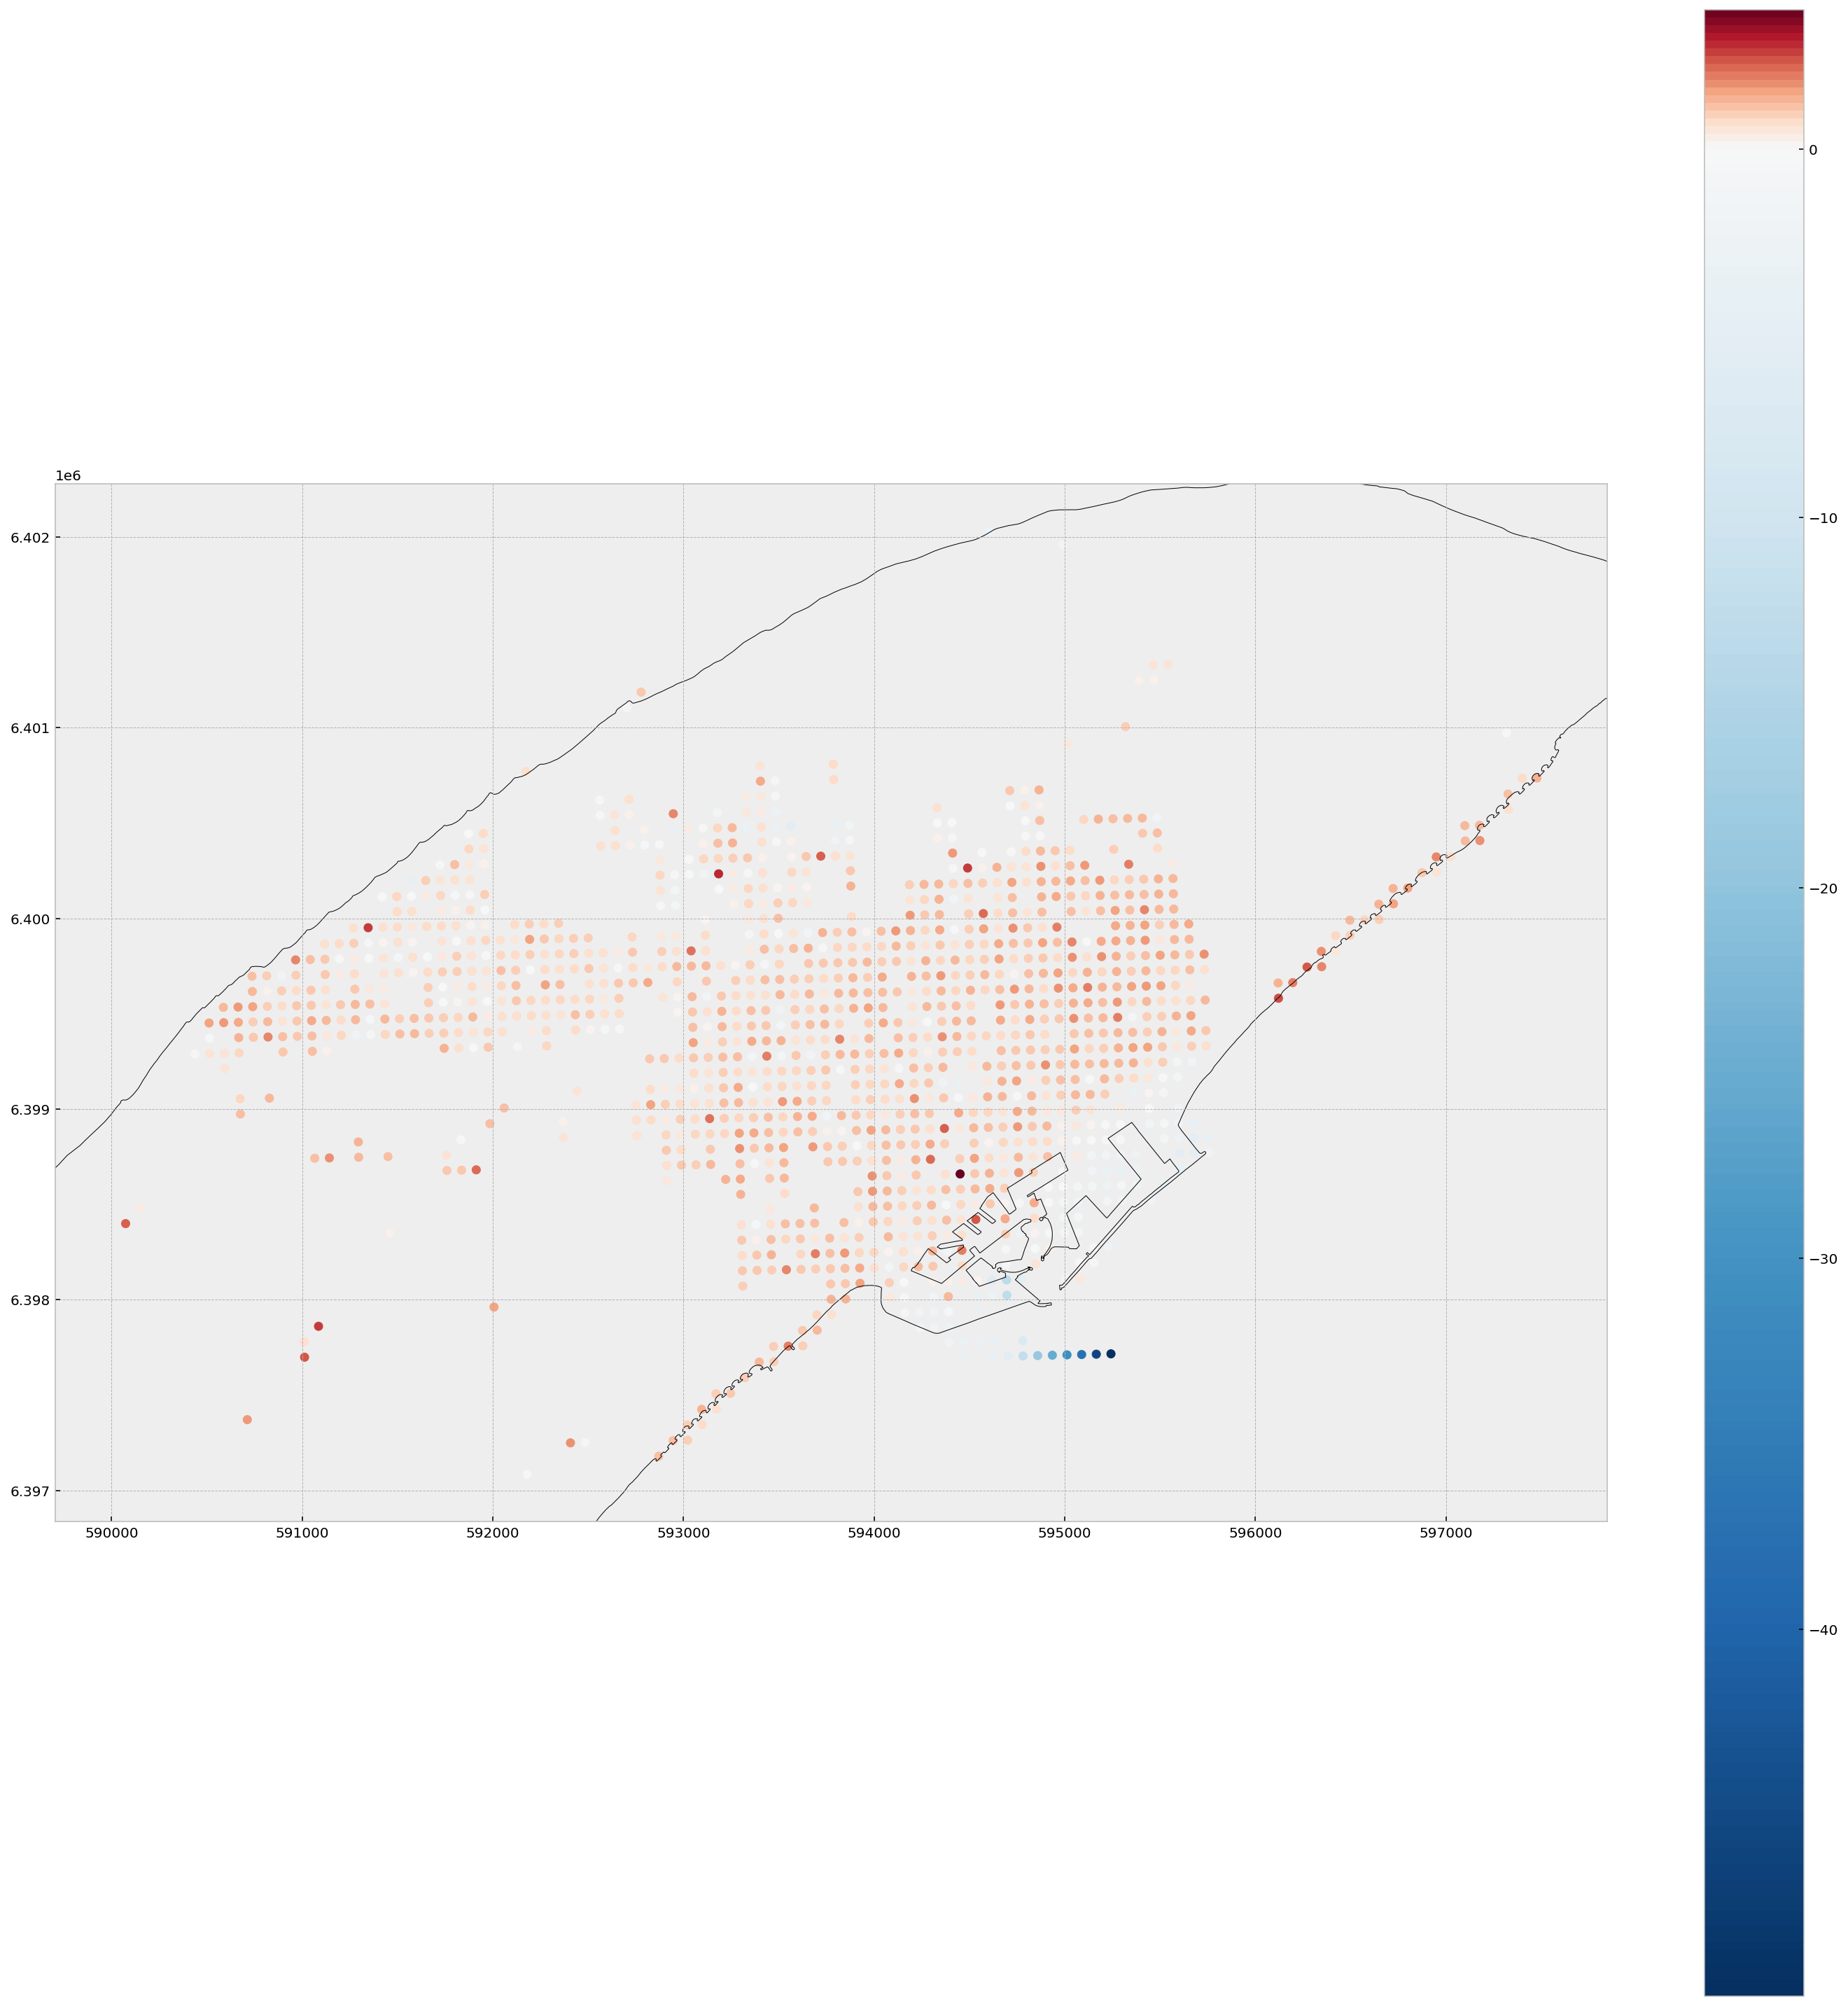

In [8]:
fig, ax = plt.subplots(figsize=(20, 20))
points.plot(column='VEL_V', ax=ax, cmap='RdBu_r', norm=norm, legend=True)
plt.autoscale(False)
adm.plot(ax=ax, color='none', edgecolor='black')
fig.tight_layout()
plt.savefig(cwd / f'test_area.pdf')

In [9]:
N = 3
N = 1
g = grid.Grid(*grid.build_grid(points.total_bounds, crs=points.crs, N_points_x=N, N_points_y=N, point_distance=POINT_DISTANCE_OBSERVED))

In [10]:
layer_columns = 'VEL_V', 'VEL_V_NOUPLIFT'
aggregates = ('count', 'mean', 'std', 'median', 'min', 'max', ('iqr', iqr),) #  ('data', list))
aggfunc = {column: aggregates for column in layer_columns}

In [11]:
g.process_points(points, aggfunc)

/home/e088195/bin/miniconda3/envs/diveg/lib/python3.8/site-packages/pandas/core/frame.py:9126: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


In [12]:
columns = [('VEL_V', 'count')]
print(f'Reduction impact: {g.reduction_impact(columns): >.2%}')
g.reduce(columns)

Reduction impact: 79.50%


In [13]:
stat = 'mean'
raster_fname = f'test_VEL_V_{stat}.tif'
g.save(raster_fname, ('VEL_V', stat))

/home/e088195/bin/miniconda3/envs/diveg/lib/python3.8/site-packages/pandas/core/common.py:237: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [14]:
image = rasterio.open(raster_fname)
type(image)
data = image.read()[0]

In [15]:
image.bounds

BoundingBox(left=590033.6621199334, bottom=6397044.108093221, right=597553.6621199334, top=6402084.108093221)

In [16]:
left, bottom, right, top = image.bounds
left, bottom, right, top

(590033.6621199334, 6397044.108093221, 597553.6621199334, 6402084.108093221)

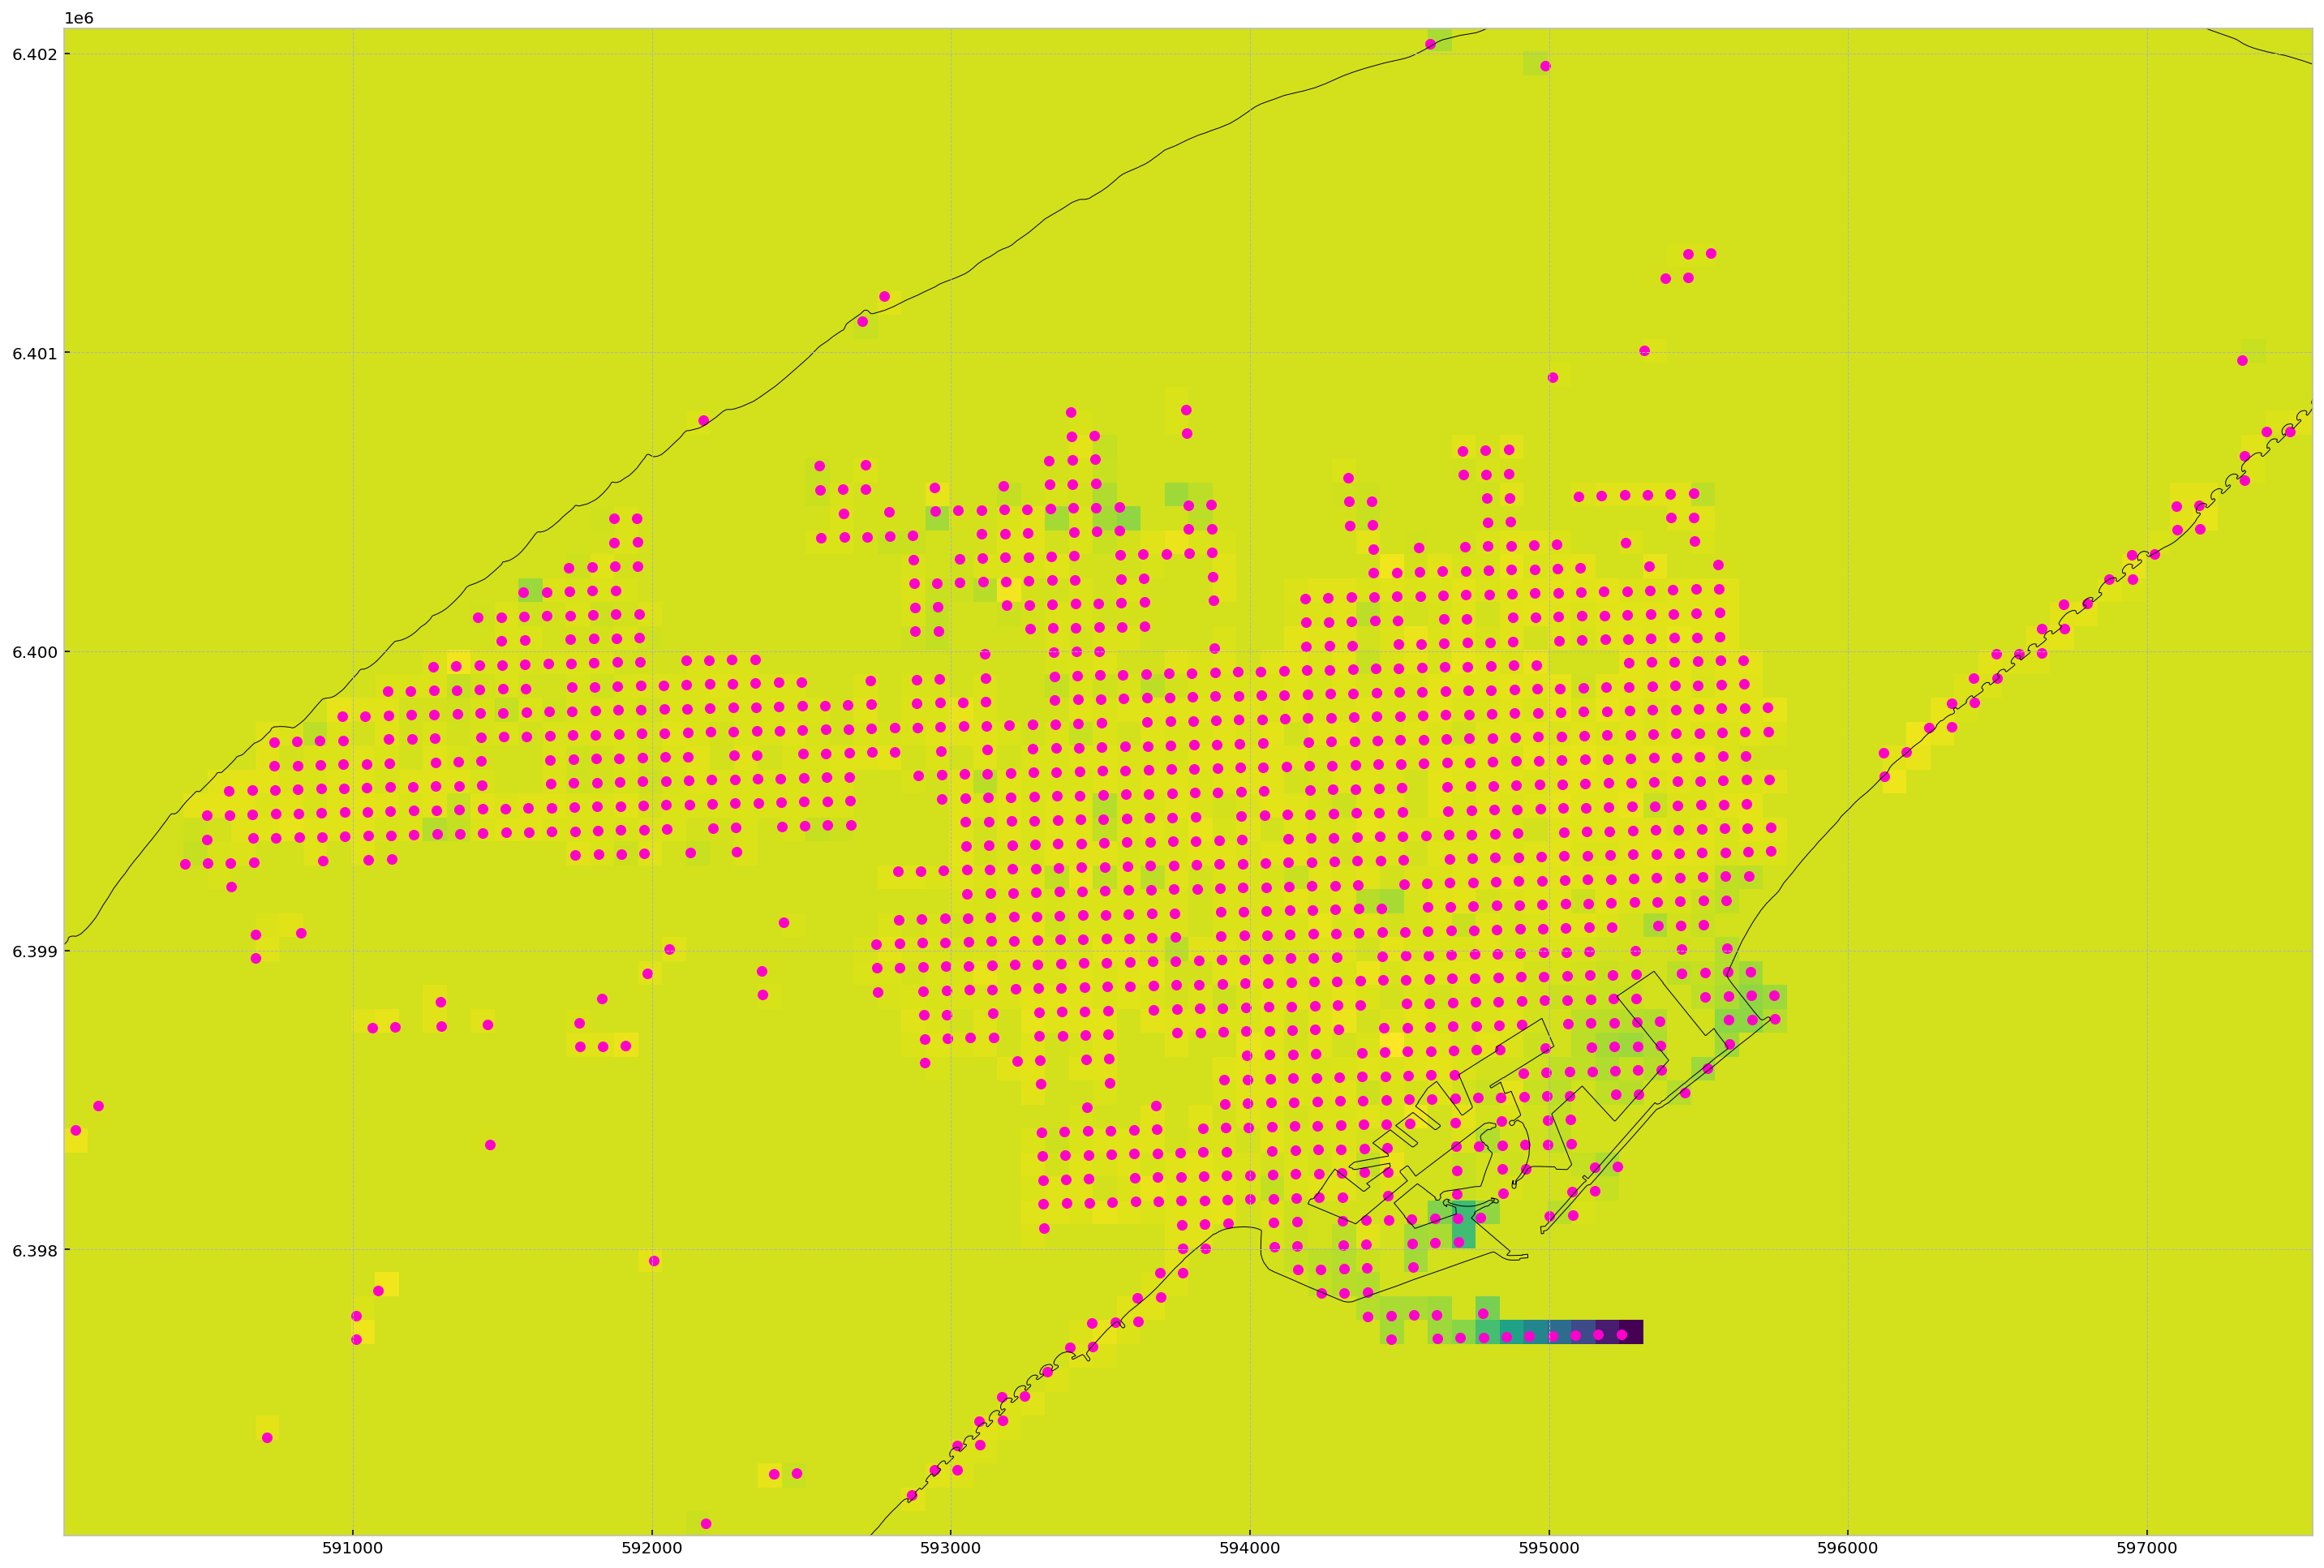

In [24]:
# Add a rectangle showing the boundary
data_bounds = mpl.patches.Rectangle(
    xy=np.array((left, bottom)),
    width=(right - left),
    height=(top - bottom),
    color='#ffcc00',
    zorder=-1,
    alpha=.5
)

data_to_plot = data.copy()
# data_to_plot[data_to_plot==g._NODATA_VALUE] = np.nan
# data_to_plot[data_to_plot==0] = np.nan

# dxy = POINT_DISTANCE_OBSERVED / 2
# ds = np.sqrt(2 * dxy)

fig, ax = plt.subplots(figsize=(20, 20))
# ax.add_patch(data_bounds)
# NOTE: Different order of the argumetns than they are received from the BoundingBox object
ax.imshow(data_to_plot, extent=np.array([left, right, bottom, top]))  # , cmap='RdBu_r', norm=norm)

# points.plot(column='VEL_V', ax=ax, cmap='RdBu_r', norm=norm, legend=True)
points.geometry.plot(ax=ax, color='#ff00cc')
plt.autoscale(False)

adm.plot(ax=ax, color='none', edgecolor='black')

fig.tight_layout()
plt.savefig(cwd / f'test_aligned.pdf')
